In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Run Simulation

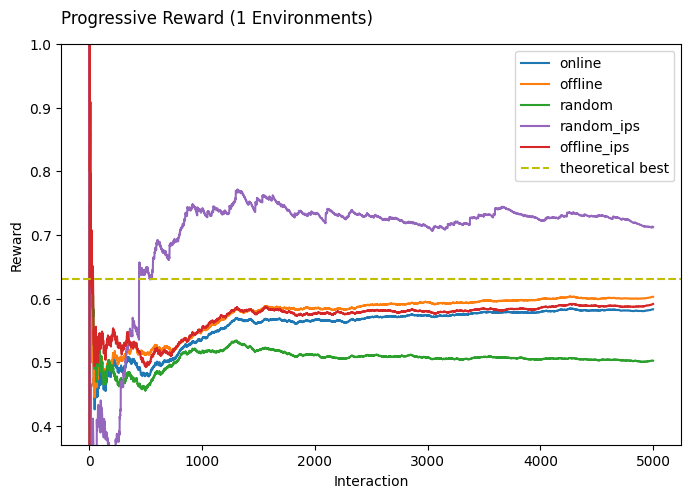

In [16]:
import ast
import pandas as pd
from datetime import datetime
import coba as cb
import numpy as np
import matplotlib.pyplot as plt
from coba.experiments.results import CustomResult
from coba.primitives.rewards import SequenceReward
from coba.environments.banditreplay import BanditReplay

class CustomEnvironment:

    def __init__(self, n_interactions):
        self._n_interactions = n_interactions

    def read(self):
        rng = cb. CobaRandom(1) #so the simulation is repeatable
        for _ in range(self._n_interactions):
            features = rng.randoms(3)
            context  = dict(zip(['feature_1','feature_2','feature_3'],features))
            rewards  = SequenceReward(np.random.binomial(1, np.clip([features[0]-.5*features[1]+.25, .5],0,1)).tolist())
            yield { 'context': context, "actions": [0,1], "rewards": rewards}

online_learners     = cb.VowpalSoftmaxLearner(features=[1, 'x', 'a', 'ax', 'axx'])
online_environments = cb.Environments(CustomEnvironment(5000))#.shuffle(n=5)
online_logged       = cb.SimpleEvaluation(record=['context','actions','rewards','action','reward','probability','ope_loss'])
online_result       = cb.Experiment(online_environments, online_learners, evaluation_task=online_logged).run(quiet=True)

# CSV serialization
df = online_result.interactions.to_pandas()
file_name = f"custom_env_mr_{datetime.now()}.csv"
df.to_csv(file_name)
df_csv = pd.read_csv(file_name, converters={column: ast.literal_eval for column in
                                            ['context', 'action', 'actions', 'probability', 'reward', 'rewards']})

offline_learners     = [cb.VowpalOffPolicyLearner([1, 'x', 'a', 'ax', 'axx']), cb.RandomLearner()]
offline_environments = BanditReplay(df_csv,take=5000)
offline_result       = cb.Experiment(offline_environments, offline_learners, evaluation_task=online_logged).run(quiet=True)

# test IPS estimation in place of the simulated rewards
df_csv = df_csv.drop(columns=['rewards'])
offline_learners_ips     = [cb.VowpalOffPolicyLearner([1, 'x', 'a', 'ax', 'axx']), cb.RandomLearner()]
offline_environments_ips = BanditReplay(df_csv,take=5000)
offline_result_ips       = cb.Experiment(offline_environments_ips, offline_learners_ips, evaluation_task=online_logged).run(quiet=True)

plt.figure(figsize=(8,8))
online_result.plot_learners(labels=['online'],colors=[0],out=None)
offline_result.plot_learners(labels=['offline','random'],colors=[1],out=None)
offline_result_ips.plot_learners(labels=['offline_ips','random_ips'],colors=[3],out=None)
plt.axhline(y = 0.63, color = 'y', linestyle = '--', label='theoretical best')
plt.legend()
plt.ylim(.37,1)
plt.show()

In [17]:
# random higher because of scaling with dividing by probability
offline_result.__class__ = CustomResult
offline_result.eval_metrics()

,learners,reward,probability,ope_loss,environment_variance
learner_id,,,,,
0,vw: --cb_adf --random_seed 1 --interactions a...,0.6028,0.9998,-0.290091,NaN
1,random: N/A,0.5022,0.5000,0.000000,NaN


In [18]:
offline_result_ips.__class__ = CustomResult
offline_result_ips.eval_metrics()

,learners,reward,probability,ope_loss,environment_variance
learner_id,,,,,
1,random: N/A,0.712396,0.5000,0.000000,NaN
0,vw: --cb_adf --random_seed 1 --interactions a...,0.591374,0.9998,-0.290091,NaN


In [19]:
online_result.__class__ = CustomResult
online_result.eval_metrics()

,learners,reward,probability,ope_loss,environment_variance
learner_id,,,,,
0,vw: --cb_explore_adf --softmax --lambda 10 --r...,0.5832,0.767168,-0.286252,NaN


In [20]:
offline_result.interactions.to_pandas()

,environment_id,learner_id,index,reward,action,actions,context,ope_loss,probability,rewards
0,0,0,1,0,0,"[0, 1]","{'feature_1': 0.10863548330962658, 'feature_2'...",0.000000,0.5,"[0, 0]"
1,0,0,2,1,1,"[0, 1]","{'feature_1': 0.17055912036448717, 'feature_2'...",0.000000,0.5,"[1, 1]"
2,0,0,3,1,1,"[0, 1]","{'feature_1': 0.3063608556985855, 'feature_2':...",-1.002878,1.0,"[1, 1]"
3,0,0,4,1,1,"[0, 1]","{'feature_1': 0.8652601158246398, 'feature_2':...",-2.002878,1.0,"[1, 1]"
4,0,0,5,0,1,"[0, 1]","{'feature_1': 0.9996601808816195, 'feature_2':...",-2.002878,1.0,"[1, 0]"
...,...,...,...,...,...,...,...,...,...,...
9995,0,1,4996,1,1,"[0, 1]","{'feature_1': 0.3790329610928893, 'feature_2':...",NaN,0.5,"[1, 1]"
9996,0,1,4997,0,0,"[0, 1]","{'feature_1': 0.2909050453454256, 'feature_2':...",NaN,0.5,"[0, 1]"
9997,0,1,4998,0,1,"[0, 1]","{'feature_1': 0.082068488933146, 'feature_2': ...",NaN,0.5,"[0, 0]"
9998,0,1,4999,0,1,"[0, 1]","{'feature_1': 0.7575294114649296, 'feature_2':...",NaN,0.5,"[1, 0]"


In [21]:
df = offline_result_ips.interactions.to_pandas()